# Collection of Analysis Related to GPS
This notebook contains the analysis for GPS related confirmations scattered
throughout other jupyter notebooks. The purpose of this notebook is to make the
information related to Sensor Confirmation pairs utilizing the GPS easier to
find during the writing of the GPS Sensor Confirmation paper.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

|    Sensor Pair            | **Idle** | **Delivery** |
|---------------------------|----------|------------|
| **GPS \& Gyroscope Heading**      | ⛔        | ✅           |
| **GPS \& Optical Flow Velocity**                   | ✅        | ✅          |
| **GPS \& Rangefinder Above-Ground-Level** | ✅        | ✅          |

## Loading Benign Data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Delivery.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

### Velocity

In [2]:
from confirmation.process import geodetic2ned, change_in_signal

gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_east = gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_down = gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds())

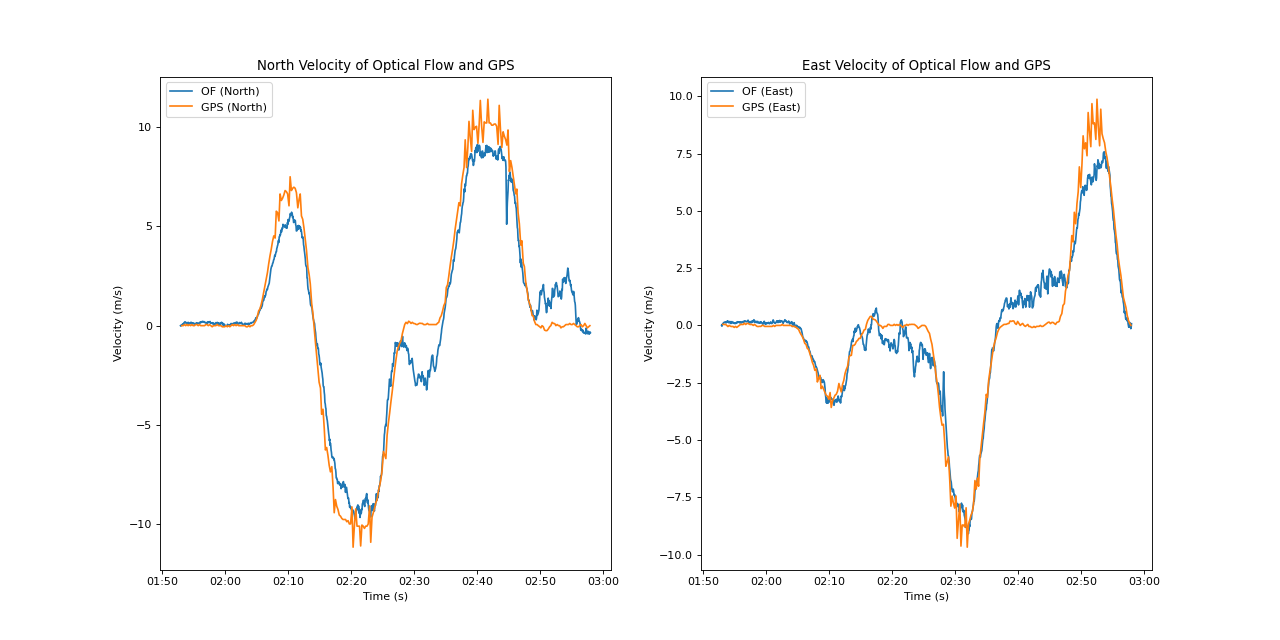

In [3]:
from confirmation.process import length, body_to_earth2D, low_pass_filter
import matplotlib.pyplot as plt
from matplotlib import dates

#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

fig = plt.figure(1, figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt.plot(ofMS.ofMS, lpf_N, label="OF (North)")
plt.plot(gpsMS.gpsMS, gps_north, label="GPS (North)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("North Velocity of Optical Flow and GPS")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend()

ax = plt.subplot(1, 2, 2)
plt.plot(ofMS.ofMS, lpf_E, label="OF (East)")
plt.plot(gpsMS.gpsMS, gps_east, label="GPS (East)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("East Velocity of Optical Flow and GPS")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend()
plt.show()

In [4]:
gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

In [5]:
from confirmation.process import signal_match_and_cumsum
#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

In [6]:
print("Max difference between GPS and OF is %f m/s" % (max(abs(gps_north - of_north).max(), abs(gps_east - of_east).max())))

Max difference between GPS and OF is 3.702608 m/s


### Altitude

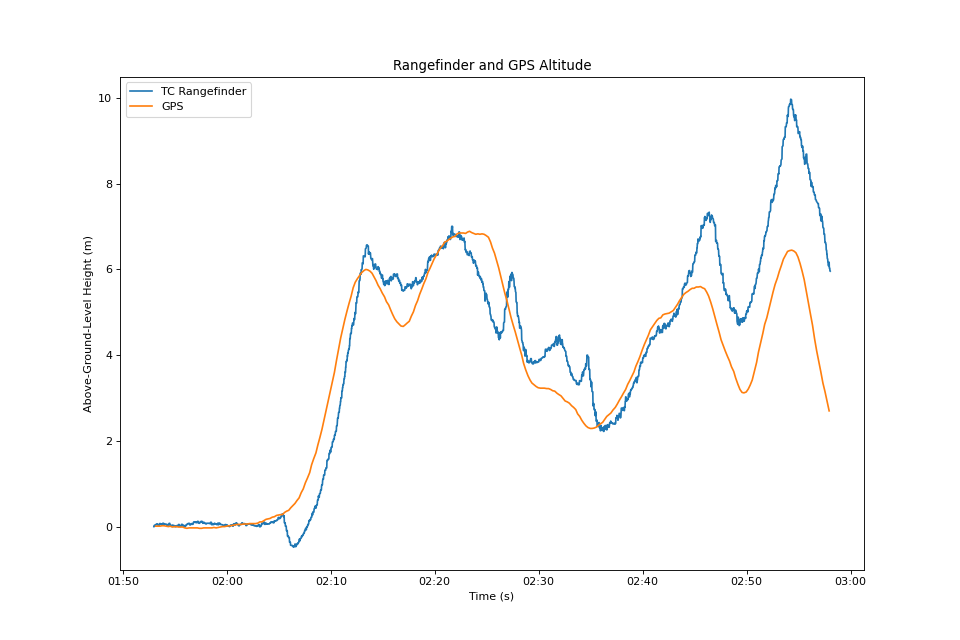

In [7]:
#Pitch information from magnetometer
from confirmation.process import mag_to_pitch
pitch = pd.DataFrame(data={'magUS':magUS.magUS, 'pitch':mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)})
#Rangefinder
rfMS['rfAlt'] = rfMS.m22.multiply(rfMS.rf/100)
#Merging pitch and rangefinder data
rf_alt = pd.merge_asof(rfMS, pitch, left_on='rfMS', right_on='magUS', direction='backward')
#Compensating pitch, tc
rf_alt['tc'] = rf_alt.rfAlt.multiply(1-(0.293*(abs(rf_alt.pitch-180)/45)))

#GPS
gps_alt = change_in_signal(gpsMS.gpAlt/100)

plt.figure(2, figsize=(12, 8), dpi=80)
ax = plt.subplot(1, 1, 1)
plt.plot(rfMS.rfMS, rf_alt.tc - rf_alt.tc[0], label="TC Rangefinder")
plt.plot(gpsMS.gpsMS[1:], gps_alt.cumsum(), label="GPS")
plt.xlabel("Time (s)")
plt.ylabel("Above-Ground-Level Height (m)")
plt.title("Rangefinder and GPS Altitude")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend()
plt.show()

In [8]:
#Matching OF to the GPS update rate
rf_alt_gps = signal_match_and_cumsum(rfMS.rfMS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(rf_alt.tc - rf_alt.tc[0]),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_alt)
rf_alt_gps = pd.Series(rf_alt_gps, name="Rangefinder AGL")

In [9]:
print("Max difference between GPS and RF is %f m" % abs(rf_alt_gps - gps_alt.cumsum()).max())

Max difference between GPS and RF is 3.824216 m


### Heading/Ground Course

The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.


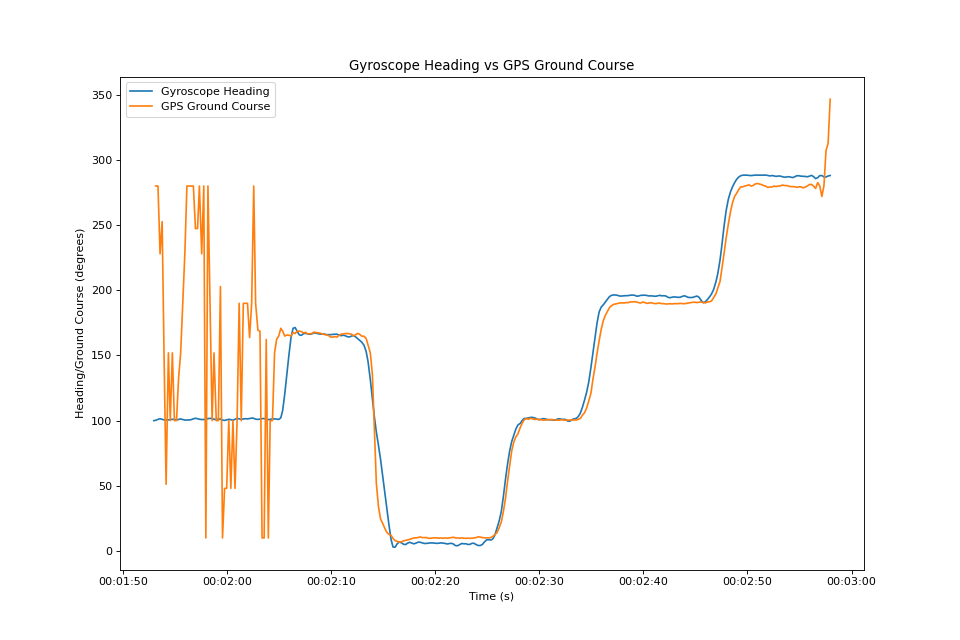

In [10]:
from math import degrees, atan2
from confirmation.process import trap_integrate, signal_match_and_cumsum

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the optical flow update rate
gyr_heading = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(gyr_heading),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")
gyr_gps_heading = (gyr_gps_heading-90)%360

plt.figure(3, figsize=(12, 8), dpi=80)
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, (gyr_gps_heading-170)%360, label="Gyroscope Heading")
plt.plot(gpsMS.gpsMS, (gps_gc-170)%360, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Heading/Ground Course (degrees)")
plt.title("Gyroscope Heading vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend()
print("The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.")
plt.show()

## Loading Malicious GPS Data

In [11]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-2000-0_4.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')

attack_end = pd.to_datetime(169700000, unit='us')
attack_start = pd.to_datetime(163475940, unit='us')

### Velocity

In [12]:
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_east = gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_down = gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds())

In [13]:
#Convert optical flow and rangefinder to OF Velocity in body frame
of_vel_bf = pd.DataFrame(data={"OF Forward":(ofMS.frF - ofMS.brF) * ofMS.rf/100,
                               "OF Right":(ofMS.frR - ofMS.brR) * ofMS.rf/100})

earth_frame = body_to_earth2D(of_vel_bf["OF Forward"], of_vel_bf["OF Right"], ofMS.m00, ofMS.m10)

lpf_E = -low_pass_filter(earth_frame.East, alpha=0.2)
lpf_N = low_pass_filter(earth_frame.North, alpha=0.2)

gps_east = pd.Series(gps_east)
lpf_E = pd.Series(lpf_E)
gps_north = pd.Series(gps_north)
lpf_N = pd.Series(lpf_N)

In [14]:
#Matching OF to the GPS update rate
of_east = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_E),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_east)
of_east = pd.Series(of_east, name="OF East, LPF")
of_north = signal_match_and_cumsum(ofMS.ofMS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(lpf_N),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_north)
of_north = pd.Series(of_north, name="OF North, LPF")

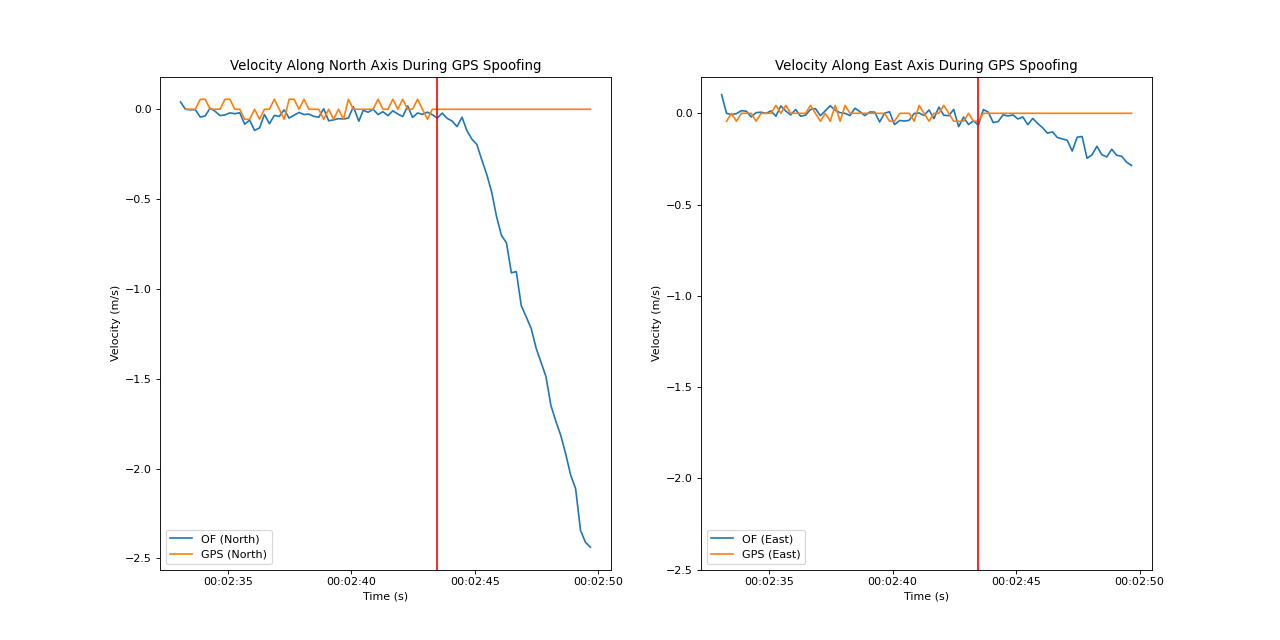

In [15]:
plt.figure(5, figsize=(16, 8), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_north[:(gpsMS.gpsMS < attack_end).sum()]-of_north[1], label="OF (North)")
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], gps_north[:(gpsMS.gpsMS < attack_end).sum()], label="GPS (North)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.subplot(1, 2, 2)
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], of_east[:(gpsMS.gpsMS < attack_end).sum()]-of_east[1], label="OF (East)")
plt.plot(gpsMS.gpsMS[1:(gpsMS.gpsMS < attack_end).sum()], gps_east[1:(gpsMS.gpsMS < attack_end).sum()], label="GPS (East)")
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.ylim(-2.5, 0.2)
plt.title("Velocity Along East Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='lower left')
plt.show()

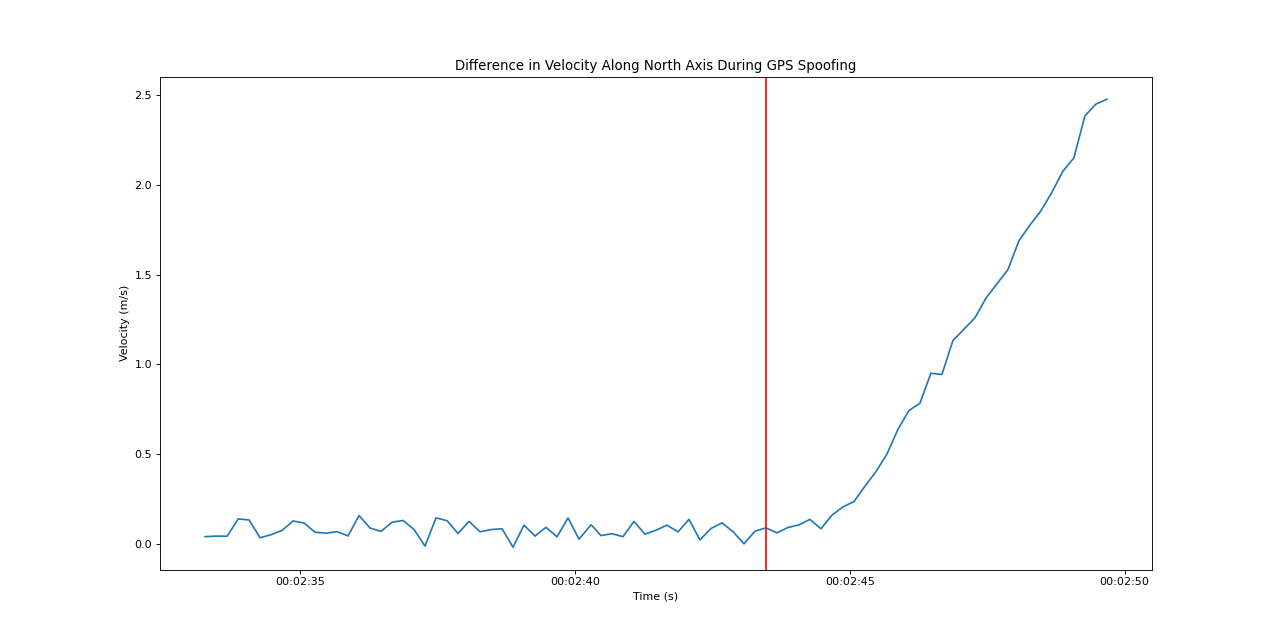

In [16]:
plt.figure(6, figsize=(16, 8), dpi=80)
plt.plot(gpsMS.gpsMS[:(gpsMS.gpsMS < attack_end).sum()], (gps_north - of_north)[:(gpsMS.gpsMS < attack_end).sum()])
plt.axvline(attack_start, color='r')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Difference in Velocity Along North Axis During GPS Spoofing")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))

In [17]:
print("Max difference between GPS and OF before attack is %f m/s and after attack is %f m/s" % (
        abs(gps_north - of_north)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_north - of_north)[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < attack_end)].max())
     )

Max difference between GPS and OF before attack is 0.158187 m/s and after attack is 2.478398 m/s


### Heading/Ground Course

The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.


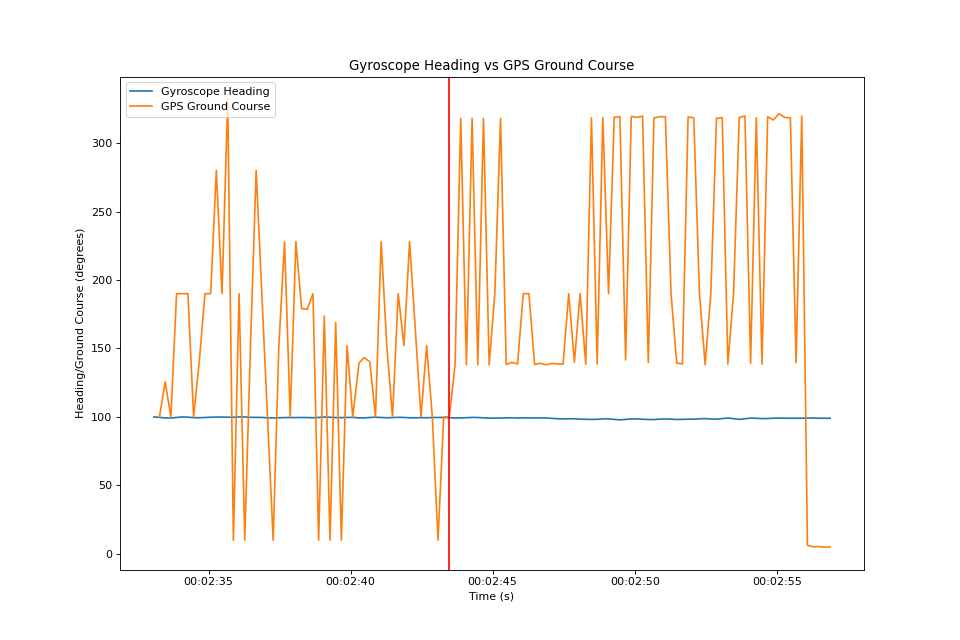

In [18]:
from math import degrees, atan2
from confirmation.process import trap_integrate, signal_match_and_cumsum

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Matching gyroscope to the optical flow update rate
gyr_heading = trap_integrate(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), cUS.gyrz).apply(degrees).cumsum() % 360
gyr_gps_heading = signal_match_and_cumsum(cUS.cUS.diff().dt.total_seconds().fillna(0).cumsum(), change_in_signal(gyr_heading),
                                          gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum(), gps_gc)
gyr_gps_heading = pd.Series(gyr_gps_heading, name="Gyroscope Heading")
gyr_gps_heading = (gyr_gps_heading-90)%360

plt.figure(7, figsize=(12, 8), dpi=80)
plt.subplot(1, 1, 1)
plt.plot(gpsMS.gpsMS, (gyr_gps_heading-170)%360, label="Gyroscope Heading")
plt.plot(gpsMS.gpsMS, (gps_gc-170)%360, label="GPS Ground Course")
plt.xlabel("Time (s)")
plt.ylabel("Heading/Ground Course (degrees)")
plt.title("Gyroscope Heading vs GPS Ground Course")
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.axvline(attack_start, color='r')
ax.xaxis.set_major_formatter(dates.DateFormatter('%M:%S'))
plt.legend(loc='upper left')
print("The Heading/Ground Course shown is shifted for visibility. The values shown are not the true Heading/Ground Course.")
plt.show()

## Loading Malicious Rangefinder Data
### Altitude

In [19]:
#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-RF-5m-1cm.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(435647900, unit='us')

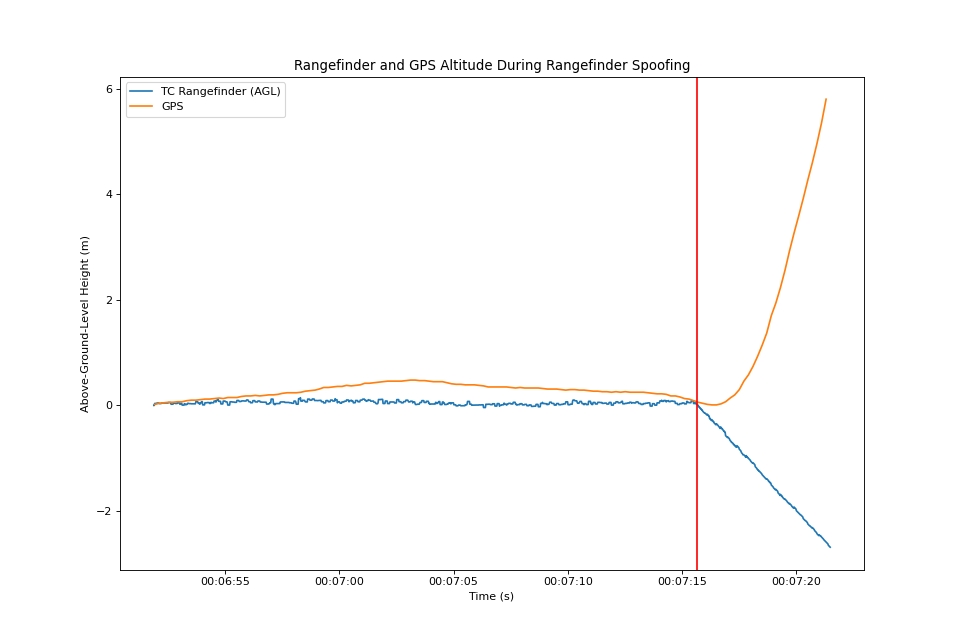

In [20]:
#Pitch information from magnetometer
from confirmation.process import mag_to_pitch

pitch = pd.DataFrame(data={'magUS':magUS.magUS, 'pitch':mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)})
#Rangefinder
rfMS['rfAlt'] = rfMS.m22.multiply(rfMS.rf/100)
#Merging pitch and rangefinder data
rf_alt = pd.merge_asof(rfMS, pitch, left_on='rfMS', right_on='magUS', direction='backward')
#Compensating pitch, tc
rf_alt['tc'] = rf_alt.rfAlt.multiply(1-(0.293*(abs(rf_alt.pitch-180)/45)))

#GPS
gps_alt = change_in_signal(gpsMS.gpAlt/100)

plt.figure(8, figsize=(12, 8), dpi=80)
ax = plt.subplot(1, 1, 1)
plt.plot(rfMS.rfMS, rf_alt.tc - rf_alt.tc[0], label="TC Rangefinder (AGL)")
plt.plot(gpsMS.gpsMS[1:], gps_alt.cumsum(), label="GPS")
plt.xlabel("Time (s)")
plt.ylabel("Above-Ground-Level Height (m)")
plt.title("Rangefinder and GPS Altitude During Rangefinder Spoofing")
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

In [21]:
#Matching RF to the GPS update rate
rf_gps = signal_match_and_cumsum(rfMS.rfMS.diff().dt.total_seconds().fillna(0).cumsum()[1:].reset_index(drop=True), change_in_signal(rf_alt.tc - rf_alt.tc[0]),
                                 gpsMS.gpsMS.diff().dt.total_seconds().fillna(0).cumsum()[1:].reset_index(drop=True), gps_alt)
rf_gps = pd.Series(rf_gps, name="TC Rangefinder (AGL)")

In [22]:
print("Max difference between GPS and RF before attack is %f m and after attack is %f m" % (
        abs(gps_alt.cumsum() - rf_gps)[gpsMS.gpsMS < attack_start].max(),
        abs(gps_alt.cumsum() - rf_gps)[(gpsMS.gpsMS >= attack_start)].max())
     )

Max difference between GPS and RF before attack is 0.470284 m and after attack is 8.485067 m


In [23]:
diff = abs(gps_alt.cumsum() - rf_gps)[(gpsMS.gpsMS >= attack_start)]
dt = (gpsMS.gpsMS[diff[diff>3.82].index[0]] - attack_start).total_seconds()
print("Time until detection: %fs" % dt)

Time until detection: 3.462100s


In [24]:
dist = of_east[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
OF_ts = gpsMS.gpsMS[(gpsMS.gpsMS >= attack_start) & (gpsMS.gpsMS < pd.Timestamp((attack_start.value/1000000000) + dt, unit='s'))]
print("Distance traveled until detection according to Optical Flow: %fm" % trapezoid(y=OF_Vel, x=OF_ts.diff().dt.total_seconds().fillna(0).cumsum()))

NameError: name 'trapezoid' is not defined